# Dueling Double DQN

_Ismaël Bonneau_


## Modèle & architecture

Comme indiqué dans le titre, ce modèle est une amélioration du **DQN**. Il reprend tous ses principes, comme le experience replay, le remplacement de la target tous les ${C}$ pas de temps, mais diffère en un point. 

Avec un **DQN**, notre réseau prend ${\phi(s)}$ en entrée et sort ${Q(s,a)}$ les valeurs des actions pour cet état ${s}$. Généralement, dans le cas d'un jeu, ${\phi(s)}$ correspond à un réseau de convolution (CNN).

Avec un **DDQN**, on prend ${\phi(s)}$ et on le traite avec 2 réseaux différents, pour produire deux sorties:
- ${V(s)}$ qui est la "valeur" de l'état, ou combien il est intéressant d'être dans cet état.
- ${A(s, a)}$ qui est la fonction avantage (rappel: <a href="">actor-critic</a>) et qui indique combien il est avantageux, quand on se trouve dans l'état ${s}$, d'effectuer l'action ${a}$ par rapport aux autres actions.

Ces deux valeurs sont ensuite combinées pour former ${Q(s,a)}$. On n'utilise pas la somme pour combiner les deux (ce qui normalement est bien la formule: ${Q(s,a) = V(s) + A(s,a)}$ mais une autre formule, ${Q(s,a) = V(s) + (A(s,a) - \frac{1}{|A|} \sum_{a}{A(s,a)})}$. (Dire pourquoi)

### Architecture du réseau de neurones:

L'architecture du modèle pour la fonction ${\phi}$ est composée d'un réseau de convolution, qui va prendre en entrée les frames du jeu (généralement stackées par groupe, nous verrons ça plus tard). Elle calcule une représentation des frames, puis la donne à l'autre partie du modèle, qui consiste en 2 branches de fully-connected.

<img src="images/dueling-q-network.png" width="600">

In [42]:
import torch
import torch.nn as nn

### La première partie du réseau:

Il s'agit de la fonction ${\phi}$. Elle est composée de 3 couches de convolution.

- 32 filtres + max-pooling 
- 64 filtres + max-pooling
- 64 filtres + max-pooling

In [43]:
class ConvNet(torch.nn.Module):
    """ Basic ConvNet similar to LeNet """
    def __init__(self, input_channel):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channel, 32, (5,5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2,2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5,5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2,2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5,5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2,2), stride=2, padding=0)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.reshape(out.size(0), -1) # flatten
        return out

### La partie dueling:

Deux branches, deux fully-connected: une pour calculer ${A(s,a)}$, une pour le calcul de ${V(s)}$. 

Il combine les deux ensuite en calculant ${Q(s,a) = V(s) + (A(s,a) - \frac{1}{|A|} \sum_{a}{A(s,a)})}$

In [65]:
class DuelingNet(torch.nn.Module):
    def __init__(self, input_dim, action_space_size):
        super(DuelingNet, self).__init__()
        # here we branch the network: one branch for V(s), another for A(s,a)
        self.V_nn = nn.Sequential(nn.Linear(input_dim, 1), nn.Tanh())
        self.advantage_nn = nn.Sequential(nn.Linear(input_dim, action_space_size), nn.Tanh())
        
    def forward(self, phi_s):
        # compute V(phi(s)) and A(phi(s))
        v = self.V_nn(phi_s)
        advantage = self.advantage_nn(phi_s)
        
        # combine the two according to the formula:
        out = v + (advantage - advantage.mean())
        return out

In [60]:
class DDQNNet(torch.nn.Module):
    def __init__(self, input_dim, action_space_size):
        super(DDQNNet, self).__init__()
        self.phi = ConvNet(input_dim)
        self.duel = DuelingNet(4094, action_space_size)
    def forward(self, x):
        return self.duel(self.phi(x))

### On peut maintenant coder le DDQN:

In [62]:
class DDQN(object):
    def __init__(self, N_STATES, N_ACTIONS, MEMORY_CAPACITY, 
                 NN_layers = [32], 
                 LR = 0.01, 
                 EPSILON = 0.1,
                 BATCH_SIZE = 32,
                 TARGET_REPLACE_ITER = 100,
                 GAMMA = 0.9):
        
        self.BATCH_SIZE = BATCH_SIZE
        self.TARGET_REPLACE_ITER = TARGET_REPLACE_ITER
        self.EPSILON = EPSILON
        self.LR = LR
        self.N_ACTIONS = N_ACTIONS
        self.N_STATES = N_STATES
        self.MEMORY_CAPACITY = MEMORY_CAPACITY
        self.GAMMA = GAMMA
        
        self.eval_net = DDQNNet(N_STATES, N_ACTIONS)
        self.target_net = DDQNNet(N_STATES, N_ACTIONS)

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.SmoothL1Loss()
    
        self.transformations = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Lambda(lambda x: transforms.functional.crop(x, 40, 30, 200, 200)), # retourne image recadrée
            transforms.Resize(64),
            transforms.ToTensor()
        ])
        
    def preprocess(self, x):
        return self.transformations(x)

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() > self.EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].item()
        else:   # random
            action = np.random.randint(0, self.N_ACTIONS)
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((self.preprocess(s), [a, r], self.preprocess(s_)))
        # replace the old memory with new memory
        index = self.memory_counter % self.MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % self.TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(self.MEMORY_CAPACITY, self.BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :self.N_STATES])
        b_a = torch.LongTensor(b_memory[:, self.N_STATES:self.N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, self.N_STATES+1:self.N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -self.N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + self.GAMMA * q_next.max(1)[0].view(self.BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Nous allons appliquer ce modèle sur un jeu bien connu, super Mario bros.

Ce jeu n'est pas disponible dans l'environnement gym par défaut. Il doit être installé à part (avec d'autres packages comme pyNes)

<img src="images/mario.gif" width="400">

Commençons par configurer notre environnement super mario bros:

In [1]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import pprint
pp = pprint.PrettyPrinter(indent=4)

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

Voici les mouvements que peut faire mario, dans notre configuration:

Pour ceux qui n'y ont jamais joué, A est la touche de saut.

In [3]:
print(SIMPLE_MOVEMENT)

[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]


La méthode _step_ de l'environnement nous renvoie le nouvel état, la récompense, un booléen indiquant si le jeu est fini et le dictionnaire _info_ qui contient des informations sur la partie: combien de pièces récoltées, combien de vies, le score, etc. L'état prend la forme d'une image, la frame du jeu.

frame shape:  (240, 256, 3)
game status: 
{   'coins': 0,
    'flag_get': False,
    'life': 2,
    'score': 0,
    'stage': 1,
    'status': 'small',
    'time': 400,
    'world': 1,
    'x_pos': 40,
    'x_pos_screen': 40,
    'y_pos': 79}


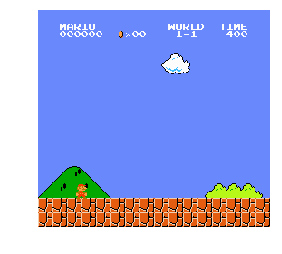

In [6]:
state = env.reset()
state, reward, done, info = env.step(env.action_space.sample())

print("frame shape: ", state.shape)
print("game status: ")
pp.pprint(info)
plt.imshow(state)
plt.axis('off')
plt.show()

## Commençons tous les pré-traitements préalables

Il faut commencer par traiter les frames. Comme on l'a vu, un état du jeu correspond à une frame de dimension ${(240, 256, 3)}$ (3 car en couleur). Il faut pré-traiter ces images pour les donner en entrée à un petit réseau de convolution ${\phi}$ qui produira ${\phi(s)}$


#### Quels sont les pré traitements que l'on peut réaliser?:

- On peut mettre en évidence artificiellement mario?
- Recadrage: on va "crop" l'image (on peut se débarasser du haut du ciel par exemple, avec le score et les vies) et redimensionner l'image qui est trop grande.
- Redimensionnement: passer d'une image ${240 \times256}$ à une image ${64 \times64}$ ne serait pas un luxe: cela diminuera le nombre de paramètres de notre CNN ${Q}$ et accélèrera l'apprentissage.

In [44]:
from PIL import Image
from matplotlib import cm
import torchvision
from torchvision import transforms

transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda x: transforms.functional.crop(x, 40, 30, 200, 200)), # retourne image recadrée
    transforms.Resize(64),
    transforms.ToTensor()
])

In [45]:
img = transformations(state)

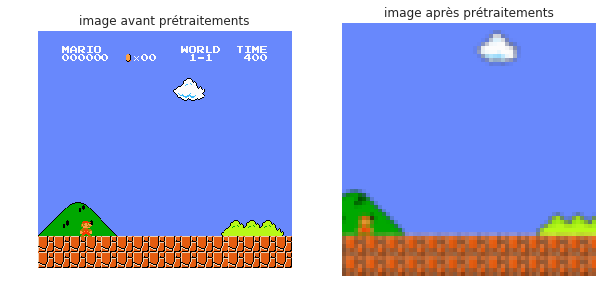

In [41]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
ax1.axis('off')
ax1.title.set_text("image avant prétraitements")
ax1.imshow(state)
ax2 = fig.add_subplot(1,2,2)
ax2.axis('off')
ax2.title.set_text("image après prétraitements")
ax2.imshow(img)
plt.show()

In [70]:
MEMORY_CAPACITY = 2000
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]
TARGET_REPLACE_ITER = 200
GAMMA = 0.9
# Enregistrement de l'Agent
ddqn = DDQN(3, N_ACTIONS, MEMORY_CAPACITY)

episode_count = 1000000
reward = 0
done = False
env.verbose = True
env.seed(0)
np.random.seed(42)
rsum = 0

for i in range(episode_count):
    obs = env.reset()
    env.verbose = (i % 100 == 0 and i > 0)  # afficher 1 episode sur 100
    if env.verbose:
        env.render()
    j = 0
    rsum = 0
    while True:
        action = ddqn.choose_action(obs)
        obs_, reward, done, _ = env.step(action)
        #s_, r, done, info = env.step(a)
        r = reward
        ddqn.store_transition(obs, action, r, obs_)
        rsum += r
        j += 1
            
        if dqn.memory_counter > MEMORY_CAPACITY:
            ddqn.learn()
                
        obs = obs_
        if env.verbose:
            env.render()
        if done:
            print("Episode : " + str(i) + " rsum=" + str(rsum) + ", " + str(j) + " actions")
            break

print("done")
env.close()

ValueError: some of the strides of a given numpy array are negative. This is currently not supported, but will be added in future releases.